In [1]:
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots

from dataset import EuXFELCurrentDataset, EuXFELLPSDataset
from legacy import SupervisedCurrentProfileInference, SupervisedLPSInference
from nils.simulate_spectrometer_signal import get_crisp_signal
from nils.reconstruction_module_after_diss import master_recon
from utils import current2formfactor


math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


In [2]:
plt.style.use(["science", "ieee"])


In [3]:
current_model = SupervisedCurrentProfileInference.load_from_checkpoint(
    "virtual-diagnostics-euxfel-current-legacy/og6sdbm0/checkpoints/epoch=76-step=29876.ckpt"
)
current_model.eval()

lps_model = SupervisedLPSInference.load_from_checkpoint(
    "virtual-diagnostics-euxfel-lps-legacy/mptc9vmu/checkpoints/epoch=95-step=35136.ckpt"
)
lps_model.eval()

print("Loaded models!")


Loaded models!


In [4]:
with open("data/zihan/train_scalers_current.pkl", "rb") as f:
    current_scalers = pickle.load(f)
current_dataset_test = EuXFELCurrentDataset(
    stage="test",
    normalize=True,
    rf_scaler=current_scalers["rf"],
    formfactor_scaler=current_scalers["formfactor"],
    current_scaler=current_scalers["current"],
    bunch_length_scaler=current_scalers["bunch_length"],
)

with open("data/zihan/train_scalers_lps.pkl", "rb") as f:
    lps_scalers = pickle.load(f)
lps_dataset_test = EuXFELLPSDataset(
    stage="test",
    normalize=True,
    rf_scaler=lps_scalers["rf"],
    formfactor_scaler=lps_scalers["formfactor"],
    lps_image_scaler=lps_scalers["lps_image"],
    lps_range_scaler=lps_scalers["lps_range"],
)


plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['font.size'] = 8.0


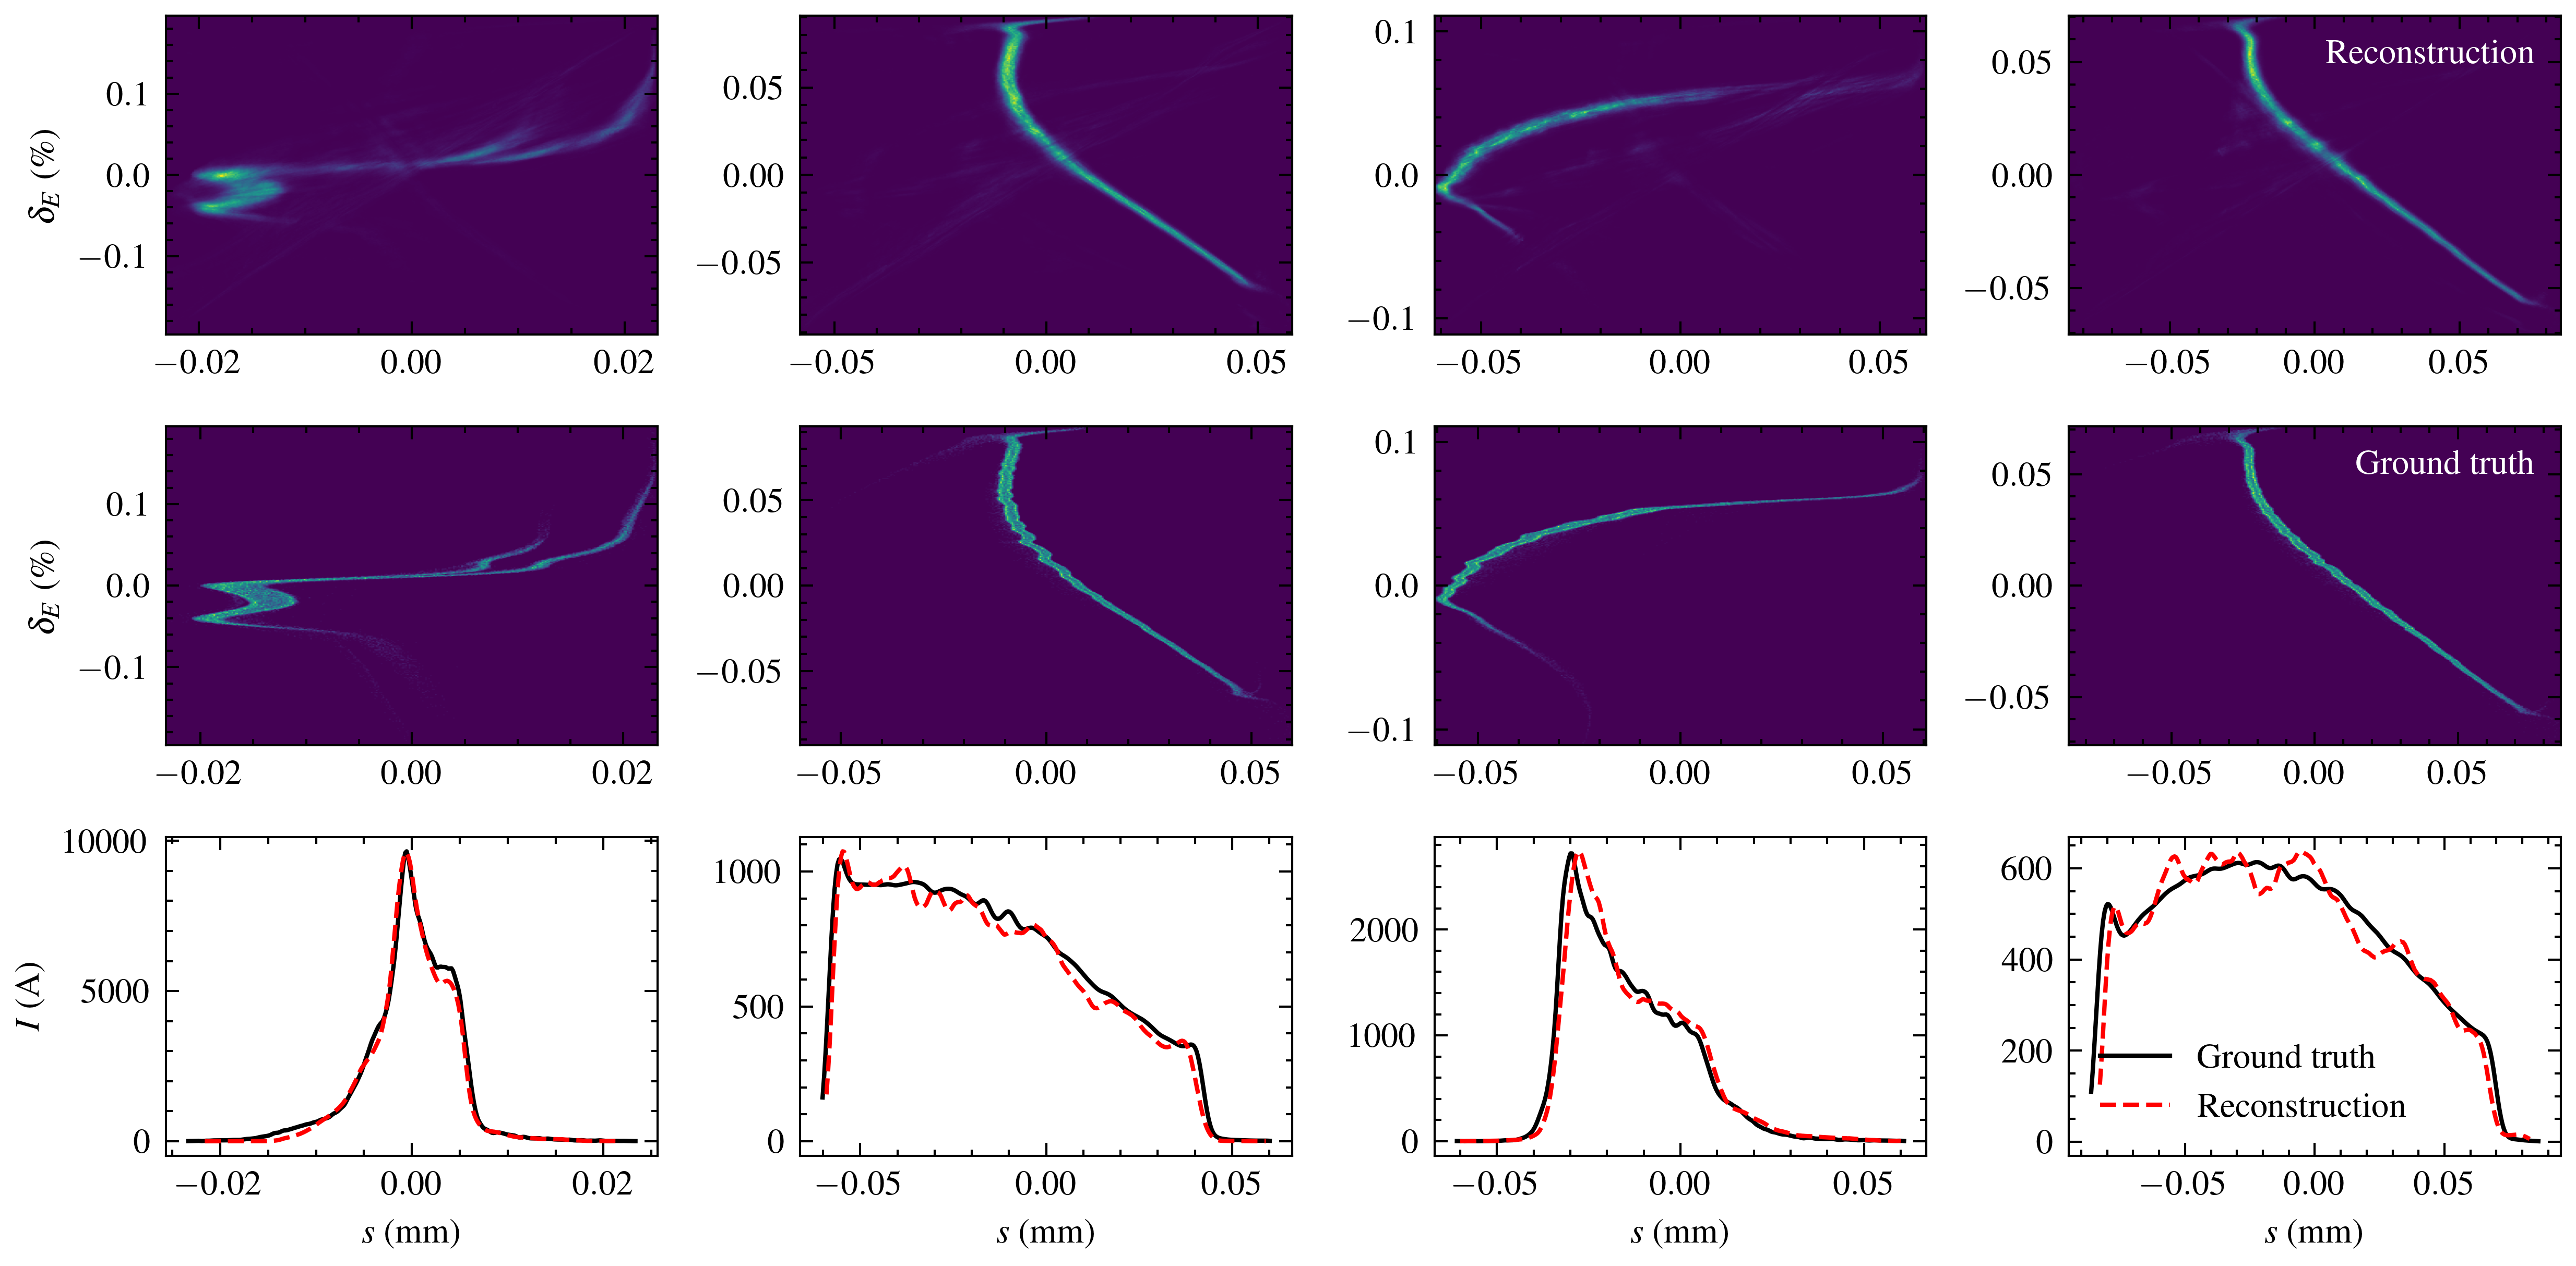

In [5]:
random.seed("IPAC")
# random.seed(24)
num_examples = 4
scale = 1.25
cmap = "viridis"
cmap_cutoff = 0
samples = random.choices(range(len(lps_dataset_test)), k=num_examples)

# Swap columns
tmp = samples[0]
samples[0] = samples[3]
samples[3] = tmp

print(f"{plt.rcParams['xtick.labelsize'] = }")
print(f"{plt.rcParams['font.size'] = }")
# print(f"{plt.rcParams = }")

plt.figure(figsize=(6.69423 * scale, 6.69423 * scale * 0.5))

for i, sample in enumerate(samples):
    (_, _), (current_profile, bunch_length) = current_dataset_test[sample]
    (rf_settings, formfactor), (lps_image, lps_range) = lps_dataset_test[sample]

    x_rf = rf_settings.reshape((1, 5))
    x_formfactor = formfactor.reshape((1, 240))

    y_hat_current_profile, y_hat_bunch_length = current_model(x_rf, x_formfactor)
    y_hat_lps_image, y_hat_lps_range = lps_model(x_rf, x_formfactor)

    predicted_current_profile = current_scalers["current"].inverse_transform(
        y_hat_current_profile.detach().numpy()
    )
    predicted_bunch_length = current_scalers["bunch_length"].inverse_transform(
        y_hat_bunch_length.detach().numpy()
    )
    predicted_lps_image = (
        lps_scalers["lps_image"]
        .inverse_transform(y_hat_lps_image.detach().numpy().reshape(1, 300 * 300))
        .reshape(1, 300, 300)
    )
    predicted_lps_range = lps_scalers["lps_range"].inverse_transform(
        y_hat_lps_range.detach().numpy()
    )

    real_ss = np.linspace(
        -current_dataset_test.bunch_lengths[sample][0] / 2,
        current_dataset_test.bunch_lengths[sample][0] / 2,
        num=300,
    )
    predicted_ss = np.linspace(
        -predicted_bunch_length[0][0] / 2, predicted_bunch_length[0][0] / 2, num=300
    )

    # nils_frequencies, nils_formfactors, nils_formfactor_noise, nils_detlim = (
    #     get_crisp_signal(
    #         real_ss,
    #         current_dataset_test.current_profiles[sample],
    #         n_shots=10,
    #         which_set="both",
    #     )
    # )
    # recon_time, recon_current, _, _, _, _ = master_recon(
    #     nils_frequencies,
    #     nils_formfactors,
    #     nils_formfactor_noise,
    #     nils_detlim,
    #     1e-10,
    #     method="KKstart",
    #     channels_to_remove=[],
    #     show_plots=False,
    # )

    plt.subplot(3, num_examples, i + 1)
    predicted_lps_image[predicted_lps_image < cmap_cutoff] = np.nan
    plt.imshow(
        predicted_lps_image[0],
        vmin=0,
        aspect="auto",
        cmap=cmap,
        extent=(
            -predicted_lps_range[0, 0] / 2 * 1e3,
            predicted_lps_range[0, 0] / 2 * 1e3,
            -predicted_lps_range[0, 1] / 2 * 1e2,
            predicted_lps_range[0, 1] / 2 * 1e2,
        ),
    )
    if i == 0:
        plt.ylabel(r"$\delta_E$ (\%)")
    if i == num_examples - 1:
        plt.text(
            0.95,
            0.85,
            "Reconstruction",
            color="white",
            horizontalalignment="right",
            transform=plt.gca().transAxes,
        )

    plt.subplot(3, num_examples, num_examples + i + 1)
    real_lps_image = lps_dataset_test.lps_images[sample].copy()
    real_lps_image[real_lps_image < cmap_cutoff] = np.nan
    plt.imshow(
        real_lps_image,
        vmin=0,
        aspect="auto",
        cmap=cmap,
        extent=(
            -lps_dataset_test.lps_ranges[sample, 0] / 2 * 1e3,
            lps_dataset_test.lps_ranges[sample, 0] / 2 * 1e3,
            -lps_dataset_test.lps_ranges[sample, 1] / 2 * 1e2,
            lps_dataset_test.lps_ranges[sample, 1] / 2 * 1e2,
        ),
    )
    if i == 0:
        plt.ylabel(r"$\delta_E$ (\%)")
    if i == num_examples - 1:
        plt.text(
            0.95,
            0.85,
            "Ground truth",
            color="white",
            horizontalalignment="right",
            transform=plt.gca().transAxes,
        )

    plt.subplot(3, num_examples, 2 * num_examples + i + 1)
    plt.plot(
        real_ss * 1e3,
        current_dataset_test.current_profiles[sample],
        label="Ground truth",
    )
    plt.plot(predicted_ss * 1e3, predicted_current_profile[0], label="Reconstruction")
    # plt.plot(recon_time, recon_current)
    plt.xlabel(r"$s$ (mm)")
    if i == 0:
        plt.ylabel(r"$I$ (A)")
    if i == num_examples - 1:
        plt.legend()

plt.tight_layout()
# plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig("figures/THPL019_f2.pdf")
plt.show()


In [11]:
plt.style.use("science")


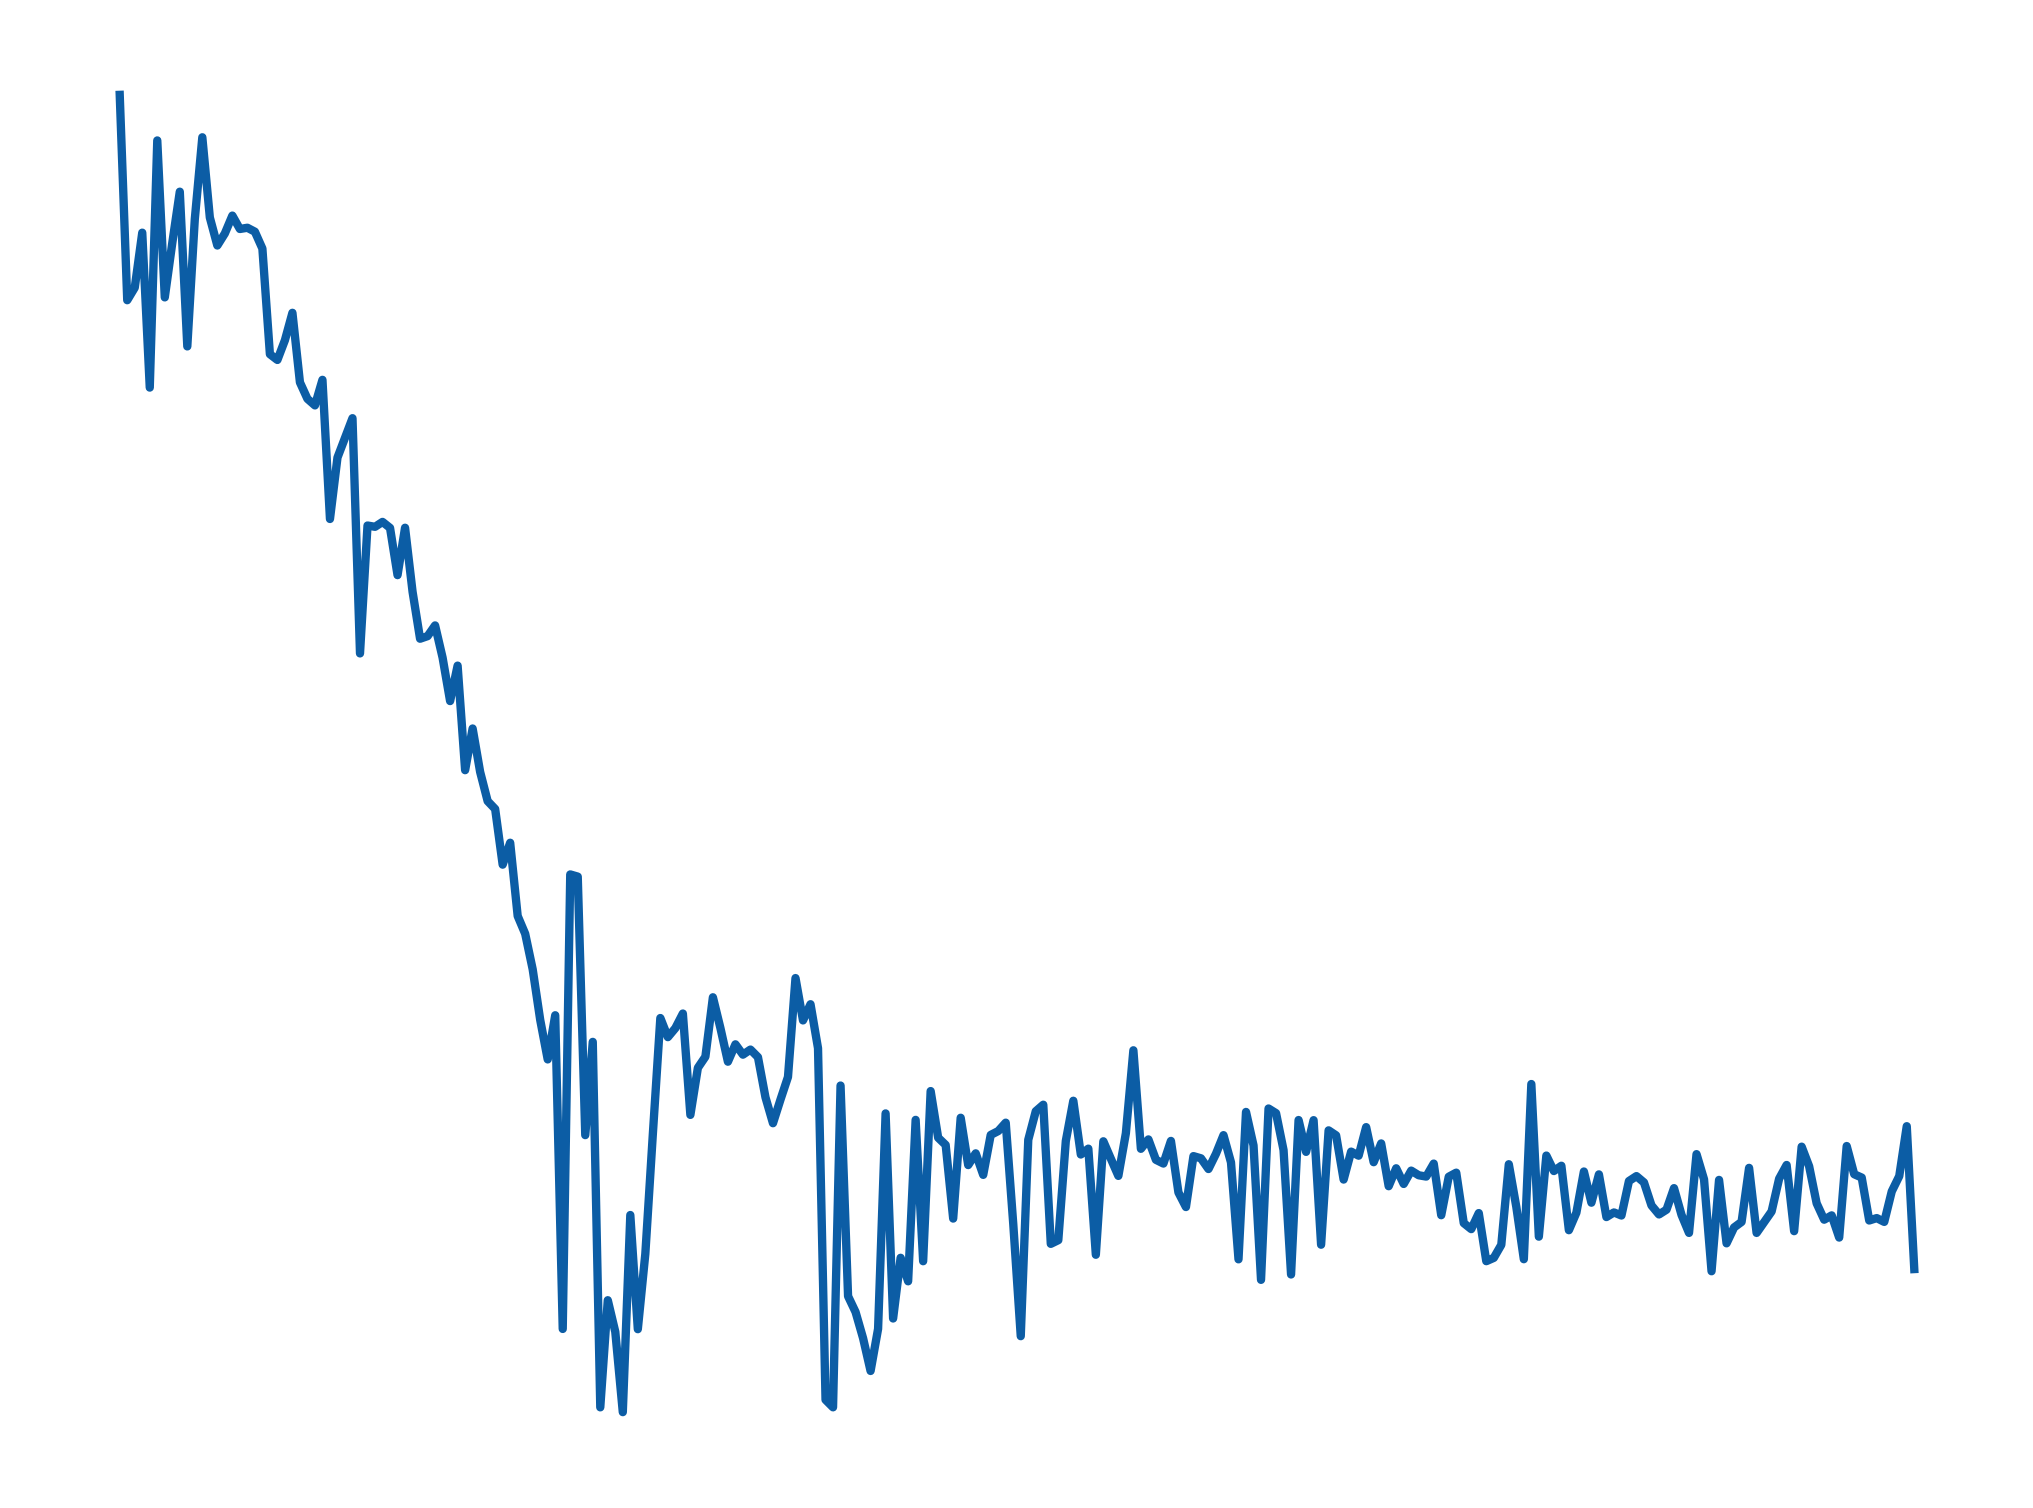

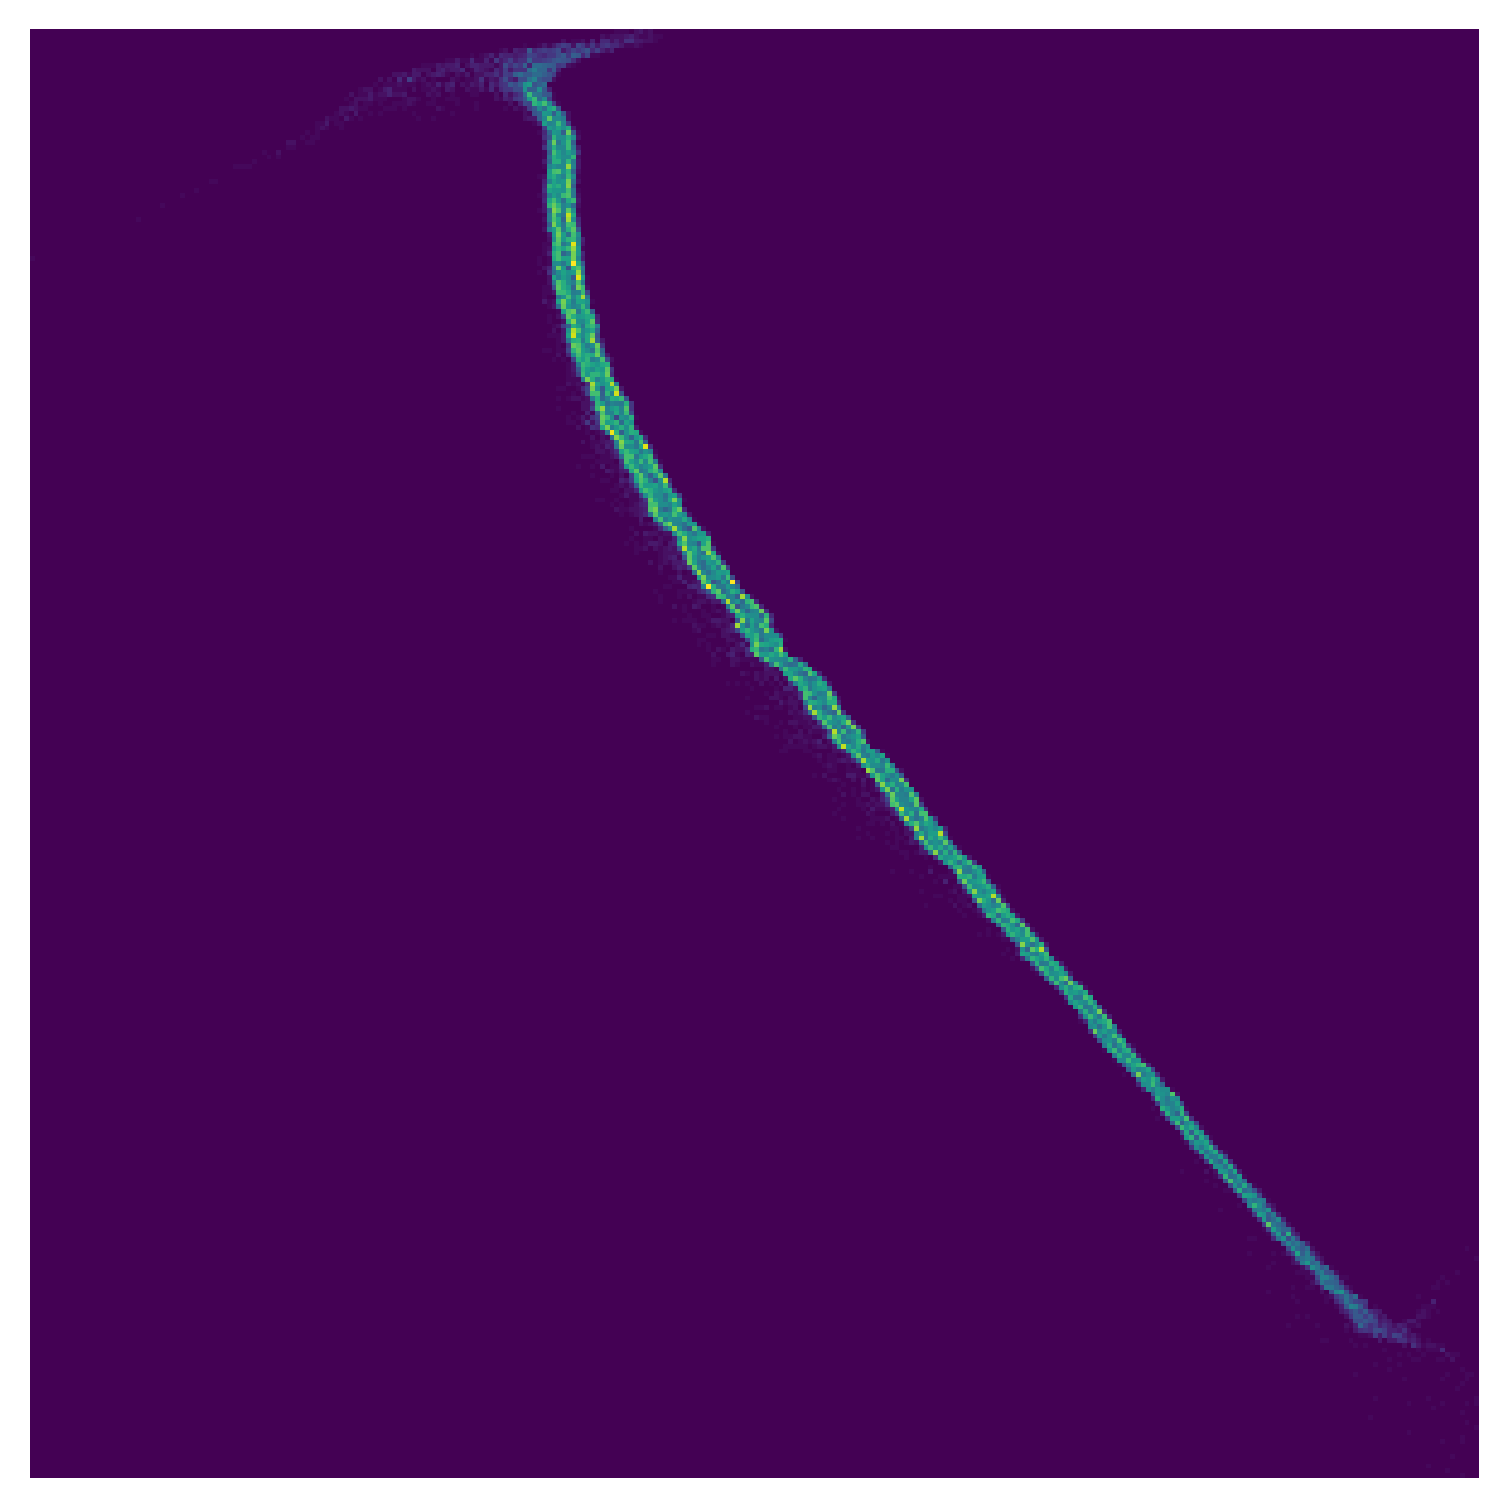

In [12]:
# For neural network flowchart in paper

plt.plot(lps_dataset_test.formfactors[samples[-1]])
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/THPL019_f1_formfactor.png", dpi=300)
plt.show()

plt.imshow(lps_dataset_test.lps_images[samples[-1]], vmin=0, interpolation="nearest")
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/THPL019_f1_lps_image.png", dpi=300)
plt.show()


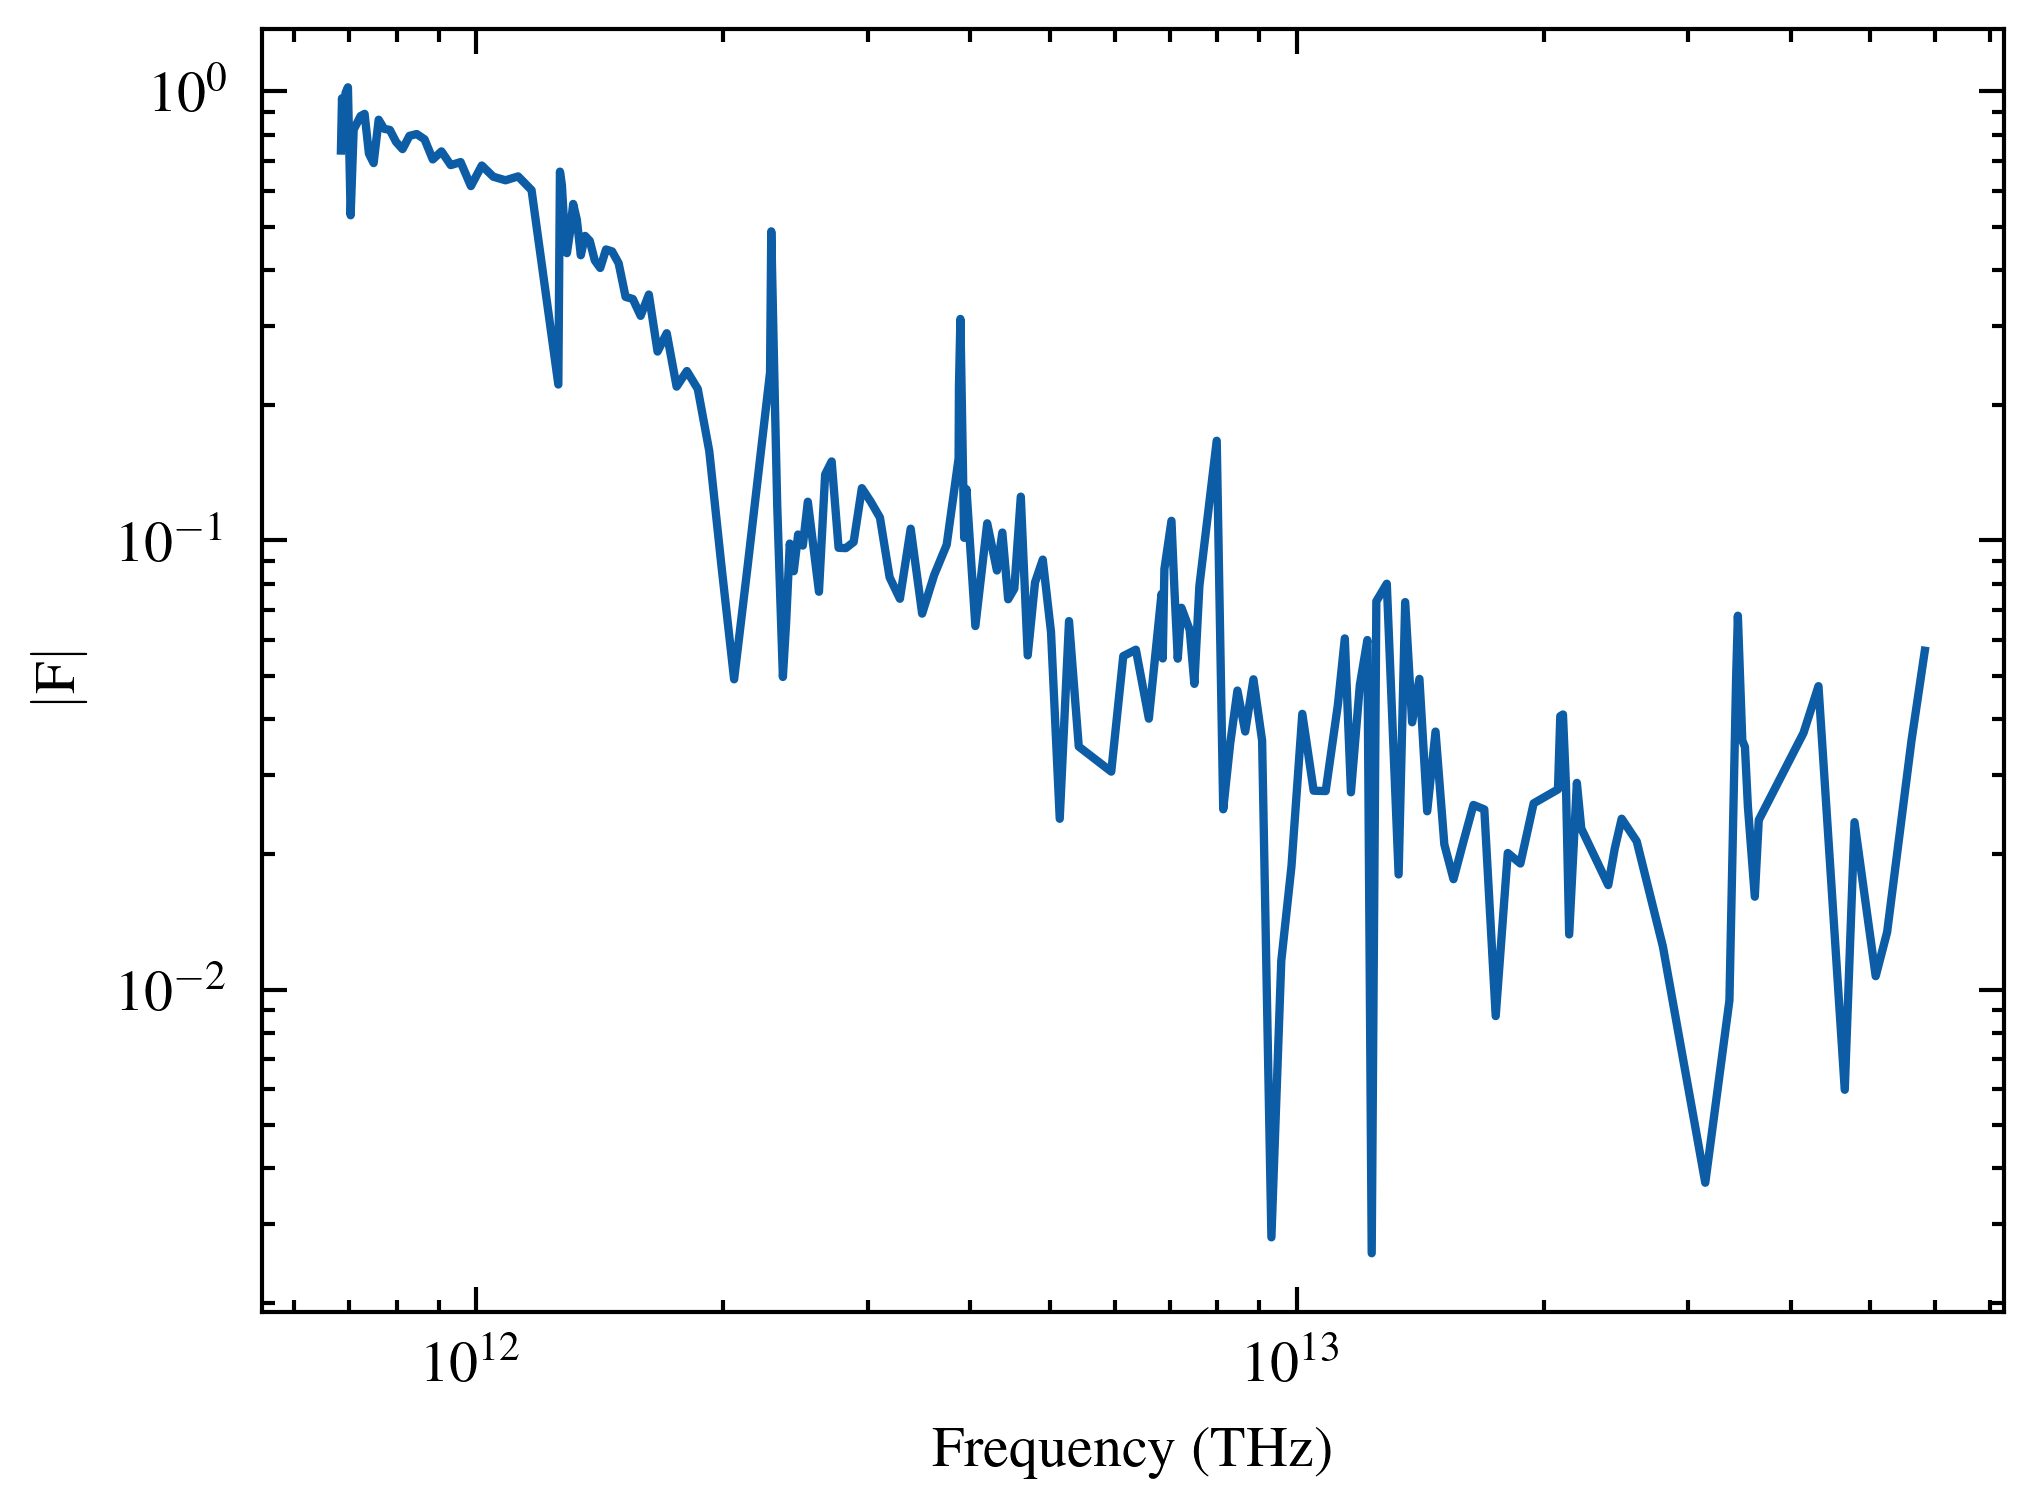

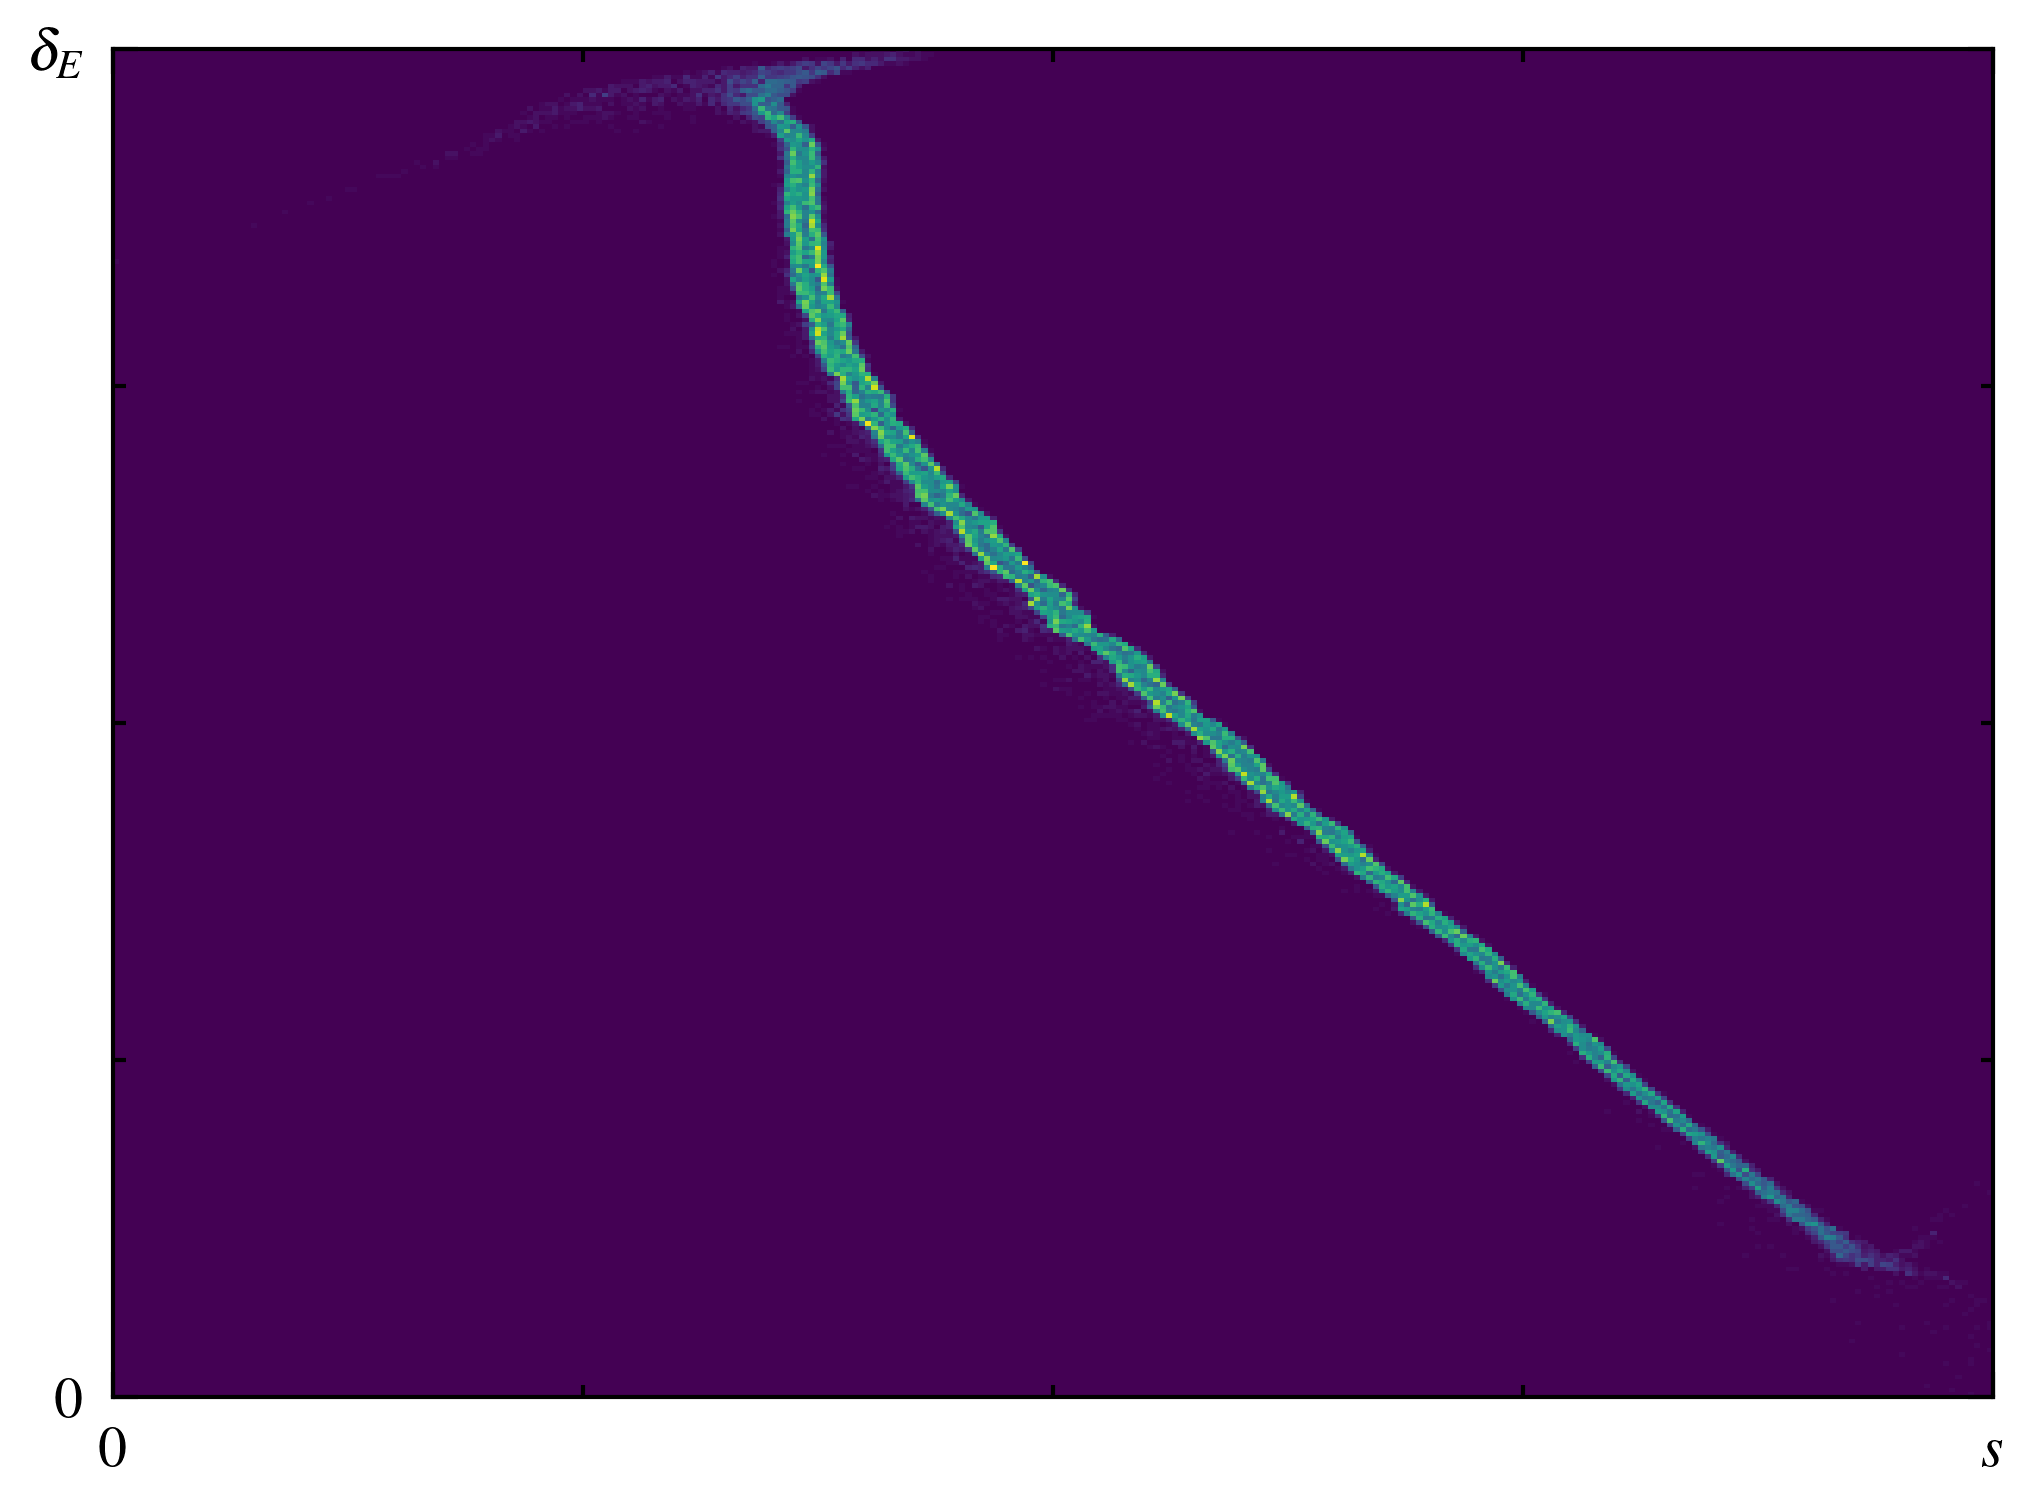

In [14]:
# For overview flowchart on poster

# Sans serif font style for poster
# plt.style.use(["science", "nature"])

df_test = pd.read_pickle(f"data/zihan/data_20220905_test.pkl")
currents = np.array(df_test.iloc[samples[-1]]["slice_I"])
ss = np.linspace(0, df_test.iloc[samples[-1]]["slice_width"] * 300, num=300)
frequencies, formfactor = current2formfactor(ss, currents)

frequencies = frequencies[formfactor > 0]
formfactor = formfactor[formfactor > 0]

plt.plot(frequencies, formfactor)
# plt.plot(lps_dataset_test.formfactors[samples[-1]])
plt.xlabel("Frequency (THz)")
plt.ylabel(r"$\left| \text{F} \right|$")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figures/poster_flowchart_formfactor.pdf", dpi=300)
plt.show()

plt.imshow(
    lps_dataset_test.lps_images[samples[-1]],
    vmin=0,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
    extent=(
        0,
        lps_dataset_test.lps_ranges[samples[-1], 0] * 1e3,
        0,
        lps_dataset_test.lps_ranges[samples[-1], 1] * 1e2,
    ),
)
plt.xticks(
    ticks=[0, lps_dataset_test.lps_ranges[samples[-1], 0] * 1e3], labels=[0, r"$s$"]
)
plt.yticks(
    ticks=[0, lps_dataset_test.lps_ranges[samples[-1], 1] * 1e2],
    labels=[0, r"$\delta_E$"],
)
plt.tight_layout()
plt.savefig("figures/poster_flowchart_lps_image.pdf", dpi=300)
plt.show()
